In [5]:
using DifferentialEquations

In [6]:
struct CRMParams
    c::Matrix{Float64}
    e::Matrix{Float64}
    K::Vector{Float64}
    m::Vector{Float64}
    S::Int64
    M::Int64
    CRMParams(c,e,K,m) = size(c,1)==size(m,1) && size(c,2)==size(K,1) && size(c) == size(e) ? new(c,e,K,m,size(m)[1],size(K)[1]) : error("parameters wrong dimensions")
end

In [7]:
function CRM!(du,u,p,t)
    @inbounds λ = @view u[1:p.S]
    @inbounds dλ = @view du[1:p.S]
    @inbounds R = @view u[end+1-p.M:end]
    @inbounds dR = @view du[end+1-p.M:end]
    dλ .= λ .* (p.c * R .- p.m)
    dR .= R .* (p.K .- R .-  p.e' * λ)
end

CRM! (generic function with 1 method)

In [8]:
M = 200;
S = 200;
μc = 1e0M;
μe = 1e0M;
σc = 2e-1sqrt(M);
σe = 2e-1sqrt(M);
K = 1e0;
σK = 1e-1;
m = 1e0;
σm = 1e-1;

In [9]:
using BenchmarkTools

In [181]:
function runCRM(ρ)
    tmax = 5000;
    K0 = K .+ σK*randn(M);
    params = randn(M,S) |> d -> CRMParams(μc/M .+ (σc/sqrt(M)).*d,μe/M .+ (σe/sqrt(M)).*(ρ.*d .+ sqrt(1-ρ^2).*randn(M,S)),K0,m .+ σm*randn(S))
    u0=vcat(ones(S)/S,K0)
    tspan=(0.0,tmax + 0.25);
    prob = ODEProblem(CRM!,u0,tspan,params);
    sol = solve(prob,maxiters=Int64(1e7),abstol=1e-15,reltol=1e-15,saveat=(tmax-0.25):0.05:tmax+0.25);
    # sol = solve(prob,dtmin=1e-15,maxiters=1e8,abstol=1e-16,reltol=1e-16,saveat=(tmax-0.25):0.05:tmax+0.25);
    return sol
end


runCRM (generic function with 1 method)

In [142]:
@time sol = runCRM(0.01);

  2.904178 seconds (501.93 k allocations: 866.491 MiB, 1.86% gc time)


In [143]:
@benchmark runCRM(0.01)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.480 s …    2.898 s  ┊ GC (min … max): 2.23% … 1.44%
 Time  (median):     2.689 s               ┊ GC (median):    1.80%
 Time  (mean ± σ):   2.689 s ± 295.339 ms  ┊ GC (mean ± σ):  1.80% ± 0.57%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.48 s         Histogram: frequency by time          2.9 s <

 Memory estimate: 677.73 MiB, allocs estimate: 392449.

In [27]:
using ThreadsX, BenchmarkTools

In [30]:
@benchmark ThreadsX.collect(randn(1000).^2 for _ in 1:1000)

BenchmarkTools.Trial: 2411 samples with 1 evaluation.
 Range (min … max):  797.541 μs … 39.571 ms  ┊ GC (min … max):  0.00% … 96.90%
 Time  (median):       1.119 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):     2.069 ms ±  5.469 ms  ┊ GC (mean ± σ):  45.54% ± 16.22%

  █▂                                                            
  ██▆▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▆▅▅▆▆▆▆ █
  798 μs        Histogram: log(frequency) by time      34.2 ms <

 Memory estimate: 15.59 MiB, allocs estimate: 2349.

In [31]:
@benchmark collect(randn(1000).^2 for _ in 1:1000)


BenchmarkTools.Trial: 1395 samples with 1 evaluation.
 Range (min … max):  2.280 ms … 13.036 ms  ┊ GC (min … max):  0.00% … 76.65%
 Time  (median):     2.886 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.583 ms ±  2.060 ms  ┊ GC (mean ± σ):  19.21% ± 21.35%

    ▆██▆▃▂▂▁                                                  
  ▇█████████▇▆▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▅▆▇███▇██▇▆▇█▆▆ █
  2.28 ms      Histogram: log(frequency) by time     10.5 ms <

 Memory estimate: 15.51 MiB, allocs estimate: 2001.

In [114]:
mewdat = [runCRM(0.01) for _ in 1:40];


In [123]:
maximum((X->sum(abs.(X(5000,Val{1})))).(mewdat))

2.8682588977132786e-24

In [17]:
onedat = ThreadsX.collect(runCRM(1.0) for _ in 1:200);

In [11]:
using ThreadsX

In [9]:
onedat = [zeros(400) for _ in 1:200];
onedatprime = [zeros(400) for _ in 1:200];

In [16]:
using ThreadsX

In [17]:
test = ThreadsX.collect(runCRM(1.0) for _ in 1:50)

LoadError: TaskFailedException

[91m    nested task error: [39mTaskFailedException
    Stacktrace:
     [1] [0m[1mwait[22m
    [90m   @ [39m[90m./[39m[90m[4mtask.jl:345[24m[39m[90m [inlined][39m
     [2] [0m[1mfetch[22m
    [90m   @ [39m[90m./[39m[90m[4mtask.jl:360[24m[39m[90m [inlined][39m
     [3] [0m[1m_reduce[22m[0m[1m([22m[90mctx[39m::[0mTransducers.CancellableDACContext, [90mrf[39m::[0mTransducers.Reduction[90m{Transducers.Map{var"#13#14"}, Transducers.Reduction{Transducers.Map{Type{BangBang.NoBang.SingletonVector}}, Transducers.BottomRF{Transducers.Completing{typeof(BangBang.append!!)}}}}[39m, [90minit[39m::[0mBangBang.NoBang.Empty[90m{Vector}[39m, [90mreducible[39m::[0mTransducers.SizedReducible[90m{UnitRange{Int64}, Int64}[39m[0m[1m)[22m
    [90m   @ [39m[35mTransducers[39m [90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mreduce.jl:160[24m[39m
     [4] [0m[1m(::Transducers.var"#167#168"{Transducers.Reduction{Transducers.Map{var"#13#14"}, Transducers.Reduction{Transducers.Map{Type{BangBang.NoBang.SingletonVector}}, Transducers.BottomRF{Transducers.Completing{typeof(BangBang.append!!)}}}}, BangBang.NoBang.Empty{Vector}, Transducers.CancellableDACContext, Transducers.SizedReducible{UnitRange{Int64}, Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mTransducers[39m [90m./[39m[90m[4mthreadingconstructs.jl:258[24m[39m
    
    [91m    nested task error: [39mInterruptException:
        Stacktrace:
          [1] [0m[1mArray[22m
        [90m    @ [39m[90m./[39m[90m[4mboot.jl:459[24m[39m[90m [inlined][39m
          [2] [0m[1mArray[22m
        [90m    @ [39m[90m./[39m[90m[4mboot.jl:468[24m[39m[90m [inlined][39m
          [3] [0m[1msimilar[22m
        [90m    @ [39m[90m./[39m[90m[4marray.jl:378[24m[39m[90m [inlined][39m
          [4] [0m[1msimilar[22m
        [90m    @ [39m[90m./[39m[90m[4msubarray.jl:65[24m[39m[90m [inlined][39m
          [5] [0m[1msimilar[22m
        [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:797[24m[39m[90m [inlined][39m
          [6] [0m[1m*[22m
        [90m    @ [39m[90m/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/LinearAlgebra/src/[39m[90m[4mmatmul.jl:52[24m[39m[90m [inlined][39m
          [7] [0m[1mCRM![22m[0m[1m([22m[90mdu[39m::[0mVector[90m{Float64}[39m, [90mu[39m::[0mVector[90m{Float64}[39m, [90mp[39m::[0mCRMParams, [90mt[39m::[0mFloat64[0m[1m)[22m
        [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mIn[3]:6[24m[39m
          [8] [0m[1mVoid[22m
        [90m    @ [39m[90m~/.julia/packages/SciMLBase/nzvrv/src/[39m[90m[4mutils.jl:462[24m[39m[90m [inlined][39m
          [9] [0m[1m(::FunctionWrappers.CallWrapper{Nothing})[22m[0m[1m([22m[90mf[39m::[0mSciMLBase.Void[90m{typeof(CRM!)}[39m, [90marg1[39m::[0mVector[90m{Float64}[39m, [90marg2[39m::[0mVector[90m{Float64}[39m, [90marg3[39m::[0mCRMParams, [90marg4[39m::[0mFloat64[0m[1m)[22m
        [90m    @ [39m[36mFunctionWrappers[39m [90m~/.julia/packages/FunctionWrappers/Q5cBx/src/[39m[90m[4mFunctionWrappers.jl:65[24m[39m
         [10] [0m[1mmacro expansion[22m
        [90m    @ [39m[90m~/.julia/packages/FunctionWrappers/Q5cBx/src/[39m[90m[4mFunctionWrappers.jl:137[24m[39m[90m [inlined][39m
         [11] [0m[1mdo_ccall[22m
        [90m    @ [39m[90m~/.julia/packages/FunctionWrappers/Q5cBx/src/[39m[90m[4mFunctionWrappers.jl:125[24m[39m[90m [inlined][39m
         [12] [0m[1mFunctionWrapper[22m
        [90m    @ [39m[90m~/.julia/packages/FunctionWrappers/Q5cBx/src/[39m[90m[4mFunctionWrappers.jl:144[24m[39m[90m [inlined][39m
         [13] [0m[1m_call[22m
        [90m    @ [39m[90m~/.julia/packages/FunctionWrappersWrappers/YyXoO/src/[39m[90m[4mFunctionWrappersWrappers.jl:12[24m[39m[90m [inlined][39m
         [14] [0m[1mFunctionWrappersWrapper[22m
        [90m    @ [39m[90m~/.julia/packages/FunctionWrappersWrappers/YyXoO/src/[39m[90m[4mFunctionWrappersWrappers.jl:10[24m[39m[90m [inlined][39m
         [15] [0m[1mODEFunction[22m
        [90m    @ [39m[90m~/.julia/packages/SciMLBase/nzvrv/src/[39m[90m[4mscimlfunctions.jl:2096[24m[39m[90m [inlined][39m
         [16] [0m[1mperform_step![22m[0m[1m([22m[90mintegrator[39m::[0mOrdinaryDiffEq.ODEIntegrator[90m{CompositeAlgorithm{Tuple{Vern9, KenCarp47{1, false, LUFactorization{LinearAlgebra.RowMaximum}, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}}, OrdinaryDiffEq.AutoSwitchCache{Vern9, KenCarp47{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}, true, Vector{Float64}, Nothing, Float64, CRMParams, Float64, Float64, Float64, Float64, Vector{Vector{Float64}}, ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, CRMParams, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, CompositeAlgorithm{Tuple{Vern9, KenCarp47{1, false, LUFactorization{LinearAlgebra.RowMaximum}, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}}, OrdinaryDiffEq.AutoSwitchCache{Vern9, KenCarp47{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}, OrdinaryDiffEq.CompositeInterpolationData{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.CompositeCache{Tuple{OrdinaryDiffEq.Vern9Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}, OrdinaryDiffEq.KenCarp47Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.NLSolver{NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, true, Vector{Float64}, Float64, Nothing, Float64, OrdinaryDiffEq.NLNewtonCache{Vector{Float64}, Float64, Float64, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, SciMLBase.UJacobianWrapper{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Float64, CRMParams}, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, LinearSolve.LinearCache{Matrix{Float64}, Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, LUFactorization{LinearAlgebra.RowMaximum}, LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, LinearSolve.InvPreconditioner{LinearAlgebra.Diagonal{Float64, Vector{Float64}}}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, Nothing}}}, OrdinaryDiffEq.KenCarp47Tableau{Float64, Float64}, Nothing}}, OrdinaryDiffEq.AutoSwitchCache{Vern9, KenCarp47{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}}, DiffEqBase.DEStats, Vector{Int64}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.CompositeCache{Tuple{OrdinaryDiffEq.Vern9Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}, OrdinaryDiffEq.KenCarp47Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.NLSolver{NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, true, Vector{Float64}, Float64, Nothing, Float64, OrdinaryDiffEq.NLNewtonCache{Vector{Float64}, Float64, Float64, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, SciMLBase.UJacobianWrapper{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Float64, CRMParams}, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, LinearSolve.LinearCache{Matrix{Float64}, Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, LUFactorization{LinearAlgebra.RowMaximum}, LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, LinearSolve.InvPreconditioner{LinearAlgebra.Diagonal{Float64, Vector{Float64}}}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, Nothing}}}, OrdinaryDiffEq.KenCarp47Tableau{Float64, Float64}, Nothing}}, OrdinaryDiffEq.AutoSwitchCache{Vern9, KenCarp47{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, CallbackSet{Tuple{}, Tuple{}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Tuple{}}, Vector{Float64}, Float64, Nothing, OrdinaryDiffEq.DefaultInit}[39m, [90mcache[39m::[0mOrdinaryDiffEq.Vern9Cache[90m{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}[39m, [90mrepeat_step[39m::[0mBool[0m[1m)[22m
        [90m    @ [39m[32mOrdinaryDiffEq[39m [90m~/.julia/packages/OrdinaryDiffEq/GxEzW/src/perform_step/[39m[90m[4mverner_rk_perform_step.jl:1196[24m[39m
         [17] [0m[1mperform_step![22m
        [90m    @ [39m[90m~/.julia/packages/OrdinaryDiffEq/GxEzW/src/perform_step/[39m[90m[4mcomposite_perform_step.jl:50[24m[39m[90m [inlined][39m
         [18] [0m[1mperform_step![22m
        [90m    @ [39m[90m~/.julia/packages/OrdinaryDiffEq/GxEzW/src/perform_step/[39m[90m[4mcomposite_perform_step.jl:49[24m[39m[90m [inlined][39m
         [19] [0m[1msolve![22m[0m[1m([22m[90mintegrator[39m::[0mOrdinaryDiffEq.ODEIntegrator[90m{CompositeAlgorithm{Tuple{Vern9, KenCarp47{1, false, LUFactorization{LinearAlgebra.RowMaximum}, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}}, OrdinaryDiffEq.AutoSwitchCache{Vern9, KenCarp47{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}, true, Vector{Float64}, Nothing, Float64, CRMParams, Float64, Float64, Float64, Float64, Vector{Vector{Float64}}, ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, CRMParams, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, CompositeAlgorithm{Tuple{Vern9, KenCarp47{1, false, LUFactorization{LinearAlgebra.RowMaximum}, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}}, OrdinaryDiffEq.AutoSwitchCache{Vern9, KenCarp47{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}, OrdinaryDiffEq.CompositeInterpolationData{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.CompositeCache{Tuple{OrdinaryDiffEq.Vern9Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}, OrdinaryDiffEq.KenCarp47Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.NLSolver{NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, true, Vector{Float64}, Float64, Nothing, Float64, OrdinaryDiffEq.NLNewtonCache{Vector{Float64}, Float64, Float64, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, SciMLBase.UJacobianWrapper{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Float64, CRMParams}, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, LinearSolve.LinearCache{Matrix{Float64}, Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, LUFactorization{LinearAlgebra.RowMaximum}, LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, LinearSolve.InvPreconditioner{LinearAlgebra.Diagonal{Float64, Vector{Float64}}}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, Nothing}}}, OrdinaryDiffEq.KenCarp47Tableau{Float64, Float64}, Nothing}}, OrdinaryDiffEq.AutoSwitchCache{Vern9, KenCarp47{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}}, DiffEqBase.DEStats, Vector{Int64}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.CompositeCache{Tuple{OrdinaryDiffEq.Vern9Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}, OrdinaryDiffEq.KenCarp47Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.NLSolver{NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, true, Vector{Float64}, Float64, Nothing, Float64, OrdinaryDiffEq.NLNewtonCache{Vector{Float64}, Float64, Float64, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, SciMLBase.UJacobianWrapper{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Float64, CRMParams}, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, LinearSolve.LinearCache{Matrix{Float64}, Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, LUFactorization{LinearAlgebra.RowMaximum}, LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, LinearSolve.InvPreconditioner{LinearAlgebra.Diagonal{Float64, Vector{Float64}}}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, Nothing}}}, OrdinaryDiffEq.KenCarp47Tableau{Float64, Float64}, Nothing}}, OrdinaryDiffEq.AutoSwitchCache{Vern9, KenCarp47{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, CallbackSet{Tuple{}, Tuple{}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Tuple{}}, Vector{Float64}, Float64, Nothing, OrdinaryDiffEq.DefaultInit}[39m[0m[1m)[22m
        [90m    @ [39m[32mOrdinaryDiffEq[39m [90m~/.julia/packages/OrdinaryDiffEq/GxEzW/src/[39m[90m[4msolve.jl:514[24m[39m
         [20] [0m[1m#__solve#564[22m
        [90m    @ [39m[90m~/.julia/packages/OrdinaryDiffEq/GxEzW/src/[39m[90m[4msolve.jl:6[24m[39m[90m [inlined][39m
         [21] [0m[1m__solve[22m[0m[1m([22m::[0mODEProblem[90m{Vector{Float64}, Tuple{Float64, Float64}, true, CRMParams, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CRMParams, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, ::[0mNothing; [90mdefault_set[39m::[0mBool, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Any, NTuple{4, Symbol}, NamedTuple{(:second_time, :abstol, :reltol, :saveat), Tuple{Bool, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}}[39m[0m[1m)[22m
        [90m    @ [39m[33mDifferentialEquations[39m [90m~/.julia/packages/DifferentialEquations/yS3VA/src/[39m[90m[4mdefault_solve.jl:9[24m[39m
         [22] [0m[1m#__solve#45[22m
        [90m    @ [39m[90m~/.julia/packages/DiffEqBase/nysQq/src/[39m[90m[4msolve.jl:1098[24m[39m[90m [inlined][39m
         [23] [0m[1m#solve_call#21[22m
        [90m    @ [39m[90m~/.julia/packages/DiffEqBase/nysQq/src/[39m[90m[4msolve.jl:474[24m[39m[90m [inlined][39m
         [24] [0m[1msolve_up[22m[0m[1m([22m::[0mODEProblem[90m{Vector{Float64}, Tuple{Float64, Float64}, true, CRMParams, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(CRM!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, ::[0mNothing, ::[0mVector[90m{Float64}[39m, ::[0mCRMParams; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:abstol, :reltol, :saveat), Tuple{Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}}[39m[0m[1m)[22m
        [90m    @ [39m[35mDiffEqBase[39m [90m~/.julia/packages/DiffEqBase/nysQq/src/[39m[90m[4msolve.jl:840[24m[39m
         [25] [0m[1msolve[22m[0m[1m([22m::[0mODEProblem[90m{Vector{Float64}, Tuple{Float64, Float64}, true, CRMParams, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(CRM!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m; [90msensealg[39m::[0mNothing, [90mu0[39m::[0mNothing, [90mp[39m::[0mNothing, [90mwrap[39m::[0mVal[90m{true}[39m, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:abstol, :reltol, :saveat), Tuple{Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}}[39m[0m[1m)[22m
        [90m    @ [39m[35mDiffEqBase[39m [90m~/.julia/packages/DiffEqBase/nysQq/src/[39m[90m[4msolve.jl:803[24m[39m
         [26] [0m[1mrunCRM[22m[0m[1m([22m[90mρ[39m::[0mFloat64[0m[1m)[22m
        [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mIn[6]:8[24m[39m
         [27] [0m[1m#13[22m
        [90m    @ [39m[90m./[39m[90m[4mnone:0[24m[39m[90m [inlined][39m
         [28] [0m[1mnext[22m
        [90m    @ [39m[90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mlibrary.jl:54[24m[39m[90m [inlined][39m
         [29] [0m[1mnext[22m[0m[1m([22m[90mrf[39m::[0mTransducers.Reduction[90m{Transducers.NoComplete, Transducers.Reduction{Transducers.Map{var"#13#14"}, Transducers.Reduction{Transducers.Map{Type{BangBang.NoBang.SingletonVector}}, Transducers.BottomRF{Transducers.Completing{typeof(BangBang.append!!)}}}}}[39m, [90mresult[39m::[0mBangBang.NoBang.Empty[90m{Vector}[39m, [90minput[39m::[0mInt64[0m[1m)[22m
        [90m    @ [39m[36mTransducers[39m [90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mcore.jl:785[24m[39m
         [30] [0m[1mmacro expansion[22m
        [90m    @ [39m[90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mcore.jl:181[24m[39m[90m [inlined][39m
         [31] [0m[1m_foldl_array[22m
        [90m    @ [39m[90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mprocesses.jl:187[24m[39m[90m [inlined][39m
         [32] [0m[1m__foldl__[22m
        [90m    @ [39m[90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mprocesses.jl:182[24m[39m[90m [inlined][39m
         [33] [0m[1mfoldl_basecase[22m
        [90m    @ [39m[90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mprocesses.jl:365[24m[39m[90m [inlined][39m
         [34] [0m[1m_reduce_basecase[22m[0m[1m([22m[90mrf[39m::[0mTransducers.Reduction[90m{Transducers.Map{var"#13#14"}, Transducers.Reduction{Transducers.Map{Type{BangBang.NoBang.SingletonVector}}, Transducers.BottomRF{Transducers.Completing{typeof(BangBang.append!!)}}}}[39m, [90minit[39m::[0mBangBang.NoBang.Empty[90m{Vector}[39m, [90mreducible[39m::[0mTransducers.SizedReducible[90m{UnitRange{Int64}, Int64}[39m[0m[1m)[22m
        [90m    @ [39m[36mTransducers[39m [90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mthreading_utils.jl:58[24m[39m
         [35] [0m[1m_reduce[22m[0m[1m([22m[90mctx[39m::[0mTransducers.CancellableDACContext, [90mrf[39m::[0mTransducers.Reduction[90m{Transducers.Map{var"#13#14"}, Transducers.Reduction{Transducers.Map{Type{BangBang.NoBang.SingletonVector}}, Transducers.BottomRF{Transducers.Completing{typeof(BangBang.append!!)}}}}[39m, [90minit[39m::[0mBangBang.NoBang.Empty[90m{Vector}[39m, [90mreducible[39m::[0mTransducers.SizedReducible[90m{UnitRange{Int64}, Int64}[39m[0m[1m)[22m
        [90m    @ [39m[36mTransducers[39m [90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mreduce.jl:150[24m[39m
         [36] [0m[1m_reduce[22m[0m[1m([22m[90mctx[39m::[0mTransducers.CancellableDACContext, [90mrf[39m::[0mTransducers.Reduction[90m{Transducers.Map{var"#13#14"}, Transducers.Reduction{Transducers.Map{Type{BangBang.NoBang.SingletonVector}}, Transducers.BottomRF{Transducers.Completing{typeof(BangBang.append!!)}}}}[39m, [90minit[39m::[0mBangBang.NoBang.Empty[90m{Vector}[39m, [90mreducible[39m::[0mTransducers.SizedReducible[90m{UnitRange{Int64}, Int64}[39m[0m[1m)[22m
        [90m    @ [39m[36mTransducers[39m [90m~/.julia/packages/Transducers/iubDU/src/[39m[90m[4mreduce.jl:159[24m[39m
         [37] [0m[1m(::Transducers.var"#167#168"{Transducers.Reduction{Transducers.Map{var"#13#14"}, Transducers.Reduction{Transducers.Map{Type{BangBang.NoBang.SingletonVector}}, Transducers.BottomRF{Transducers.Completing{typeof(BangBang.append!!)}}}}, BangBang.NoBang.Empty{Vector}, Transducers.CancellableDACContext, Transducers.SizedReducible{UnitRange{Int64}, Int64}})[22m[0m[1m([22m[0m[1m)[22m
        [90m    @ [39m[36mTransducers[39m [90m./[39m[90m[4mthreadingconstructs.jl:258[24m[39m

In [182]:
@time test = [runCRM(0.0) for _ in 1:50];

┌ Warning: dt(9.094947017729282e-13) <= dtmin(9.094947017729282e-13) at t=4854.864240849605. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/eblu/.julia/packages/SciMLBase/nzvrv/src/integrator_interface.jl:518
┌ Warning: dt(9.094947017729282e-13) <= dtmin(9.094947017729282e-13) at t=3545.5785722131964. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/eblu/.julia/packages/SciMLBase/nzvrv/src/integrator_interface.jl:518
┌ Warning: dt(9.094947017729282e-13) <= dtmin(9.094947017729282e-13) at t=4084.597107741738. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/eblu/.julia/packages/SciMLBase/nzvrv/src/integrator_interface.jl:518
┌ Warning: dt(9.094947017729282e-13) <= dtmin(9.094947017729282e-13) at t=4741.909419158695. Aborting. There is either an error in your model specification or 

264.829879 seconds (19.21 M allocations: 31.795 GiB, 0.97% gc time, 0.06% compilation time)


In [192]:
for X in test 
    println("fine")
    if X.retcode != :Success
        error("Ah!")
    end
end

fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine
fine


LoadError: Ah!

: 

: 

: 

: 

In [175]:
@time test1 = [runCRM(1.0) for _ in 1:50];


151.589776 seconds (19.37 M allocations: 32.123 GiB, 1.90% gc time, 0.08% compilation time)


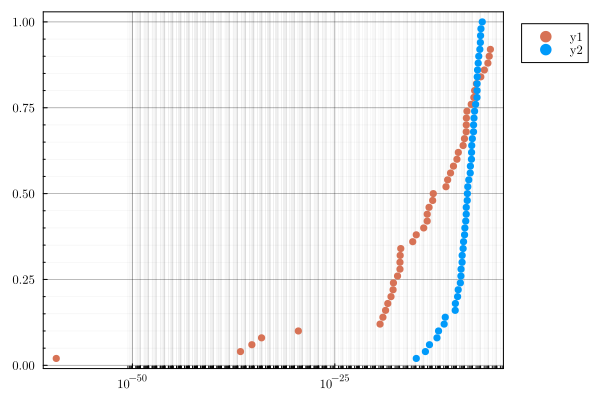

In [183]:
# maximum(filter(>(1e-18),vcat((X -> X(5000,Val{1})).(test)...)))
scatter(sort(mean.((X -> abs.(X(5000,Val{1}))).(test))),(1:50)./50,xscale=:log10)
scatter!(sort(mean.((X -> abs.(X(5000,Val{1}))).(test1))),(1:50)./50,xscale=:log10)


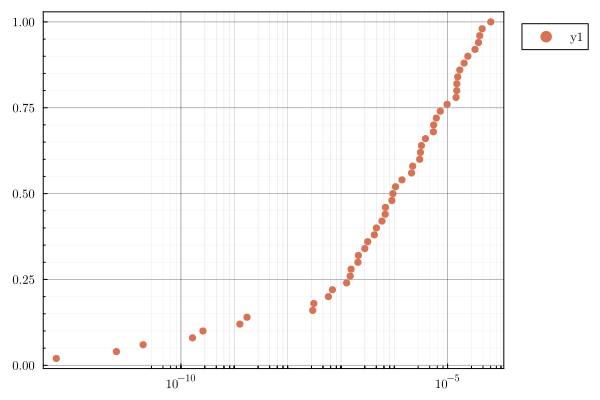

In [176]:
scatter(sort(sum.((X -> abs.(X(5000,Val{1}))).(test1))),(1:50)./50,xscale=:log10)


In [13]:
Threads.@threads for i in 1:40
    sol = runCRM(1.0);
    onedat[i] = sol(4000);
    onedatprime[i] = sol(4000,Val{1});
    println(i)
end

1
36
26
31
11
6
16
21
37
27
12
2
32
7
17
22
13
38
28
3
8
33
18
23
14
9
39
34
29
19
4
24
15
10
35
30
40
25
5
20


In [33]:
runCRM(0.1)(4000)

400-element Vector{Float64}:
  5.0e-324
  0.0
  5.0e-324
  6.669625793540064e-291
  0.0
  5.0e-324
  5.0e-324
  9.7592e-318
  5.0e-324
  1.6087901806020076e-47
  5.0e-324
  5.0e-324
 -5.0e-324
  ⋮
  5.0e-324
  5.0e-324
  0.0
  5.0e-324
  5.0e-324
  5.0e-324
  5.0e-324
  0.0
  5.0e-324
  0.0
  0.0
  5.0e-324

In [44]:
@benchmark runCRM(0.0)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/eblu/.julia/packages/SciMLBase/nzvrv/src/integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/eblu/.julia/packages/SciMLBase/nzvrv/src/integrator_interface.jl:504


BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):   93.726 ms … 251.458 s  ┊ GC (min … max): 0.00% … 1.54%
 Time  (median):     110.885 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     31.550 s ±  88.856 s  ┊ GC (mean ± σ):  1.53% ± 2.46%

  █                                                             
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  93.7 ms         Histogram: frequency by time           251 s <

 Memory estimate: 30.75 MiB, allocs estimate: 15865.

In [38]:
@time [runCRM(0.0)(4000) for _ in 1:10];

┌ Warning: dt(4.547473508864641e-13) <= dtmin(4.547473508864641e-13) at t=3422.3532617805. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/eblu/.julia/packages/SciMLBase/nzvrv/src/integrator_interface.jl:518
┌ Warning: dt(4.547473508864641e-13) <= dtmin(4.547473508864641e-13) at t=3826.649656064115. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/eblu/.julia/packages/SciMLBase/nzvrv/src/integrator_interface.jl:518


 49.632976 seconds (5.38 M allocations: 7.978 GiB, 1.03% gc time, 0.40% compilation time)


20-element Vector{Vector{Float64}}:
 [0.0, -5.0e-324, 0.0, 1.0e-323, 4.24625263429169e-273, 5.0e-324, 0.0, 1.1770162043479352e-186, 4.3396110878778293e-221, 0.0  …  0.0, 7.460213444391899e-60, 0.06856357907032391, 5.0e-324, 0.0, 2.2576009454621008e-234, 0.0, 1.1261722032594893e-197, 5.0e-324, 5.0e-324]
 [1.5e-323, 1.232019907212936e-300, -5.0e-324, 0.0, 5.0e-324, 5.0e-324, 0.0, -5.0e-324, 5.0e-324, 1.9217866142529866e-239  …  2.4588374439264562e-260, 0.0, 1.5e-323, 5.0e-324, -5.0e-324, 5.0e-324, 5.0e-324, 0.0, 0.0, 0.0]
 [5.0e-324, 0.0, 4.0e-323, 5.0e-324, 0.0, 3.8694461953841383e-100, 5.0e-324, 5.0e-324, 4.014288031606958e-194, 1.0e-323  …  4.4e-323, 2.788431770736236e-213, 0.0, 0.10069707830166294, 0.0, 0.0, 0.0, 1.0e-323, 0.0, 2.4564335173e-314]
 [1.0e-323, 5.0e-324, 5.0e-324, 3.3912599584874474e-221, 3.800058051390691e-287, 5.0e-324, 6.358888968284e-257, 2.1502351084584165e-303, 5.0e-324, 5.0e-324  …  5.0e-324, 5.0e-324, 1.0e-323, 0.0, 5.0e-324, 1.5e-323, 0.0, 3.860520793185329e-29

In [11]:
Threads.nthreads()

8

In [125]:
onedat = [runCRM(1.0)(5000.) for _ in 1:60];

In [ ]:
abs(mean((X -> mean(X[end-M+1:end] .> 10^(-3.3))).(onedat))-ϕRtheory)/ϕRtheory

0.0017438903938443995

In [ ]:
abs(mean((X -> mean(X[end-M+1:end] .> 10^(-3.3))).(onedat))-ϕRtheory)

0.00021714425172952856

In [ ]:
abs(mean((X -> mean(X[1:S] .> 10^(-2.2))).(onedat)) - ϕNtheory)/ϕNtheory


0.003200084765616691

In [ ]:
abs(mean((X -> mean(X[1:S] .> 10^(-2.2))).(onedat)) - ϕNtheory)

0.00019687521562970767

In [ ]:
ϕRtheory = 0.12451714425172955;
ϕNtheory =  0.0615218752156297;

In [ ]:
using Plots

In [ ]:
theme(:dao)

In [134]:
# mew=sort(filter(>(1e-10),vcat((X -> X[begin:end]).(onedat)...)));
mewR=sort(filter(>(1e-10),vcat((X -> X[end-M+1:end]).(onedat)...)));
mewN=sort(filter(>(1e-10),vcat((X -> X[begin:S]).(onedat)...)));

In [129]:
using Plots, PlotThemes; theme(:dao)

In [130]:
plot(mewR[1:end-1],((1/size(mewR,1))./identity(diff(mewR))),xscale=:log10,yscale=:log10)
# mew

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/eblu/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/eblu/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/eblu/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/eblu/.julia/packages/PlotUtils/M092a/src/ticks.jl:191


InexactError: InexactError: trunc(Int64, NaN)

In [131]:
plot(mewN[1:end-1],((1/size(mewN,1))./identity(diff(mewN))),xscale=:log10,yscale=:log10)


┌ Warning: No strict ticks found
└ @ PlotUtils /Users/eblu/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/eblu/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/eblu/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/eblu/.julia/packages/PlotUtils/M092a/src/ticks.jl:191


InexactError: InexactError: trunc(Int64, NaN)

In [ ]:
(X -> 10. ^(-X)).(1:10)

10-element Vector{Float64}:
 0.1
 0.010000000000000002
 0.001
 0.0001
 1.0e-5
 1.0e-6
 1.0000000000000001e-7
 1.0e-8
 1.0e-9
 1.0e-10

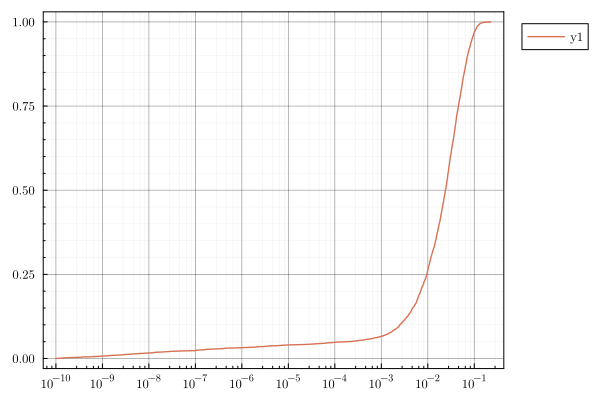

In [ ]:
plot(mewR,(1:size(mewR,1))./size(mewR,1),xscale=:log10,xticks= [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])

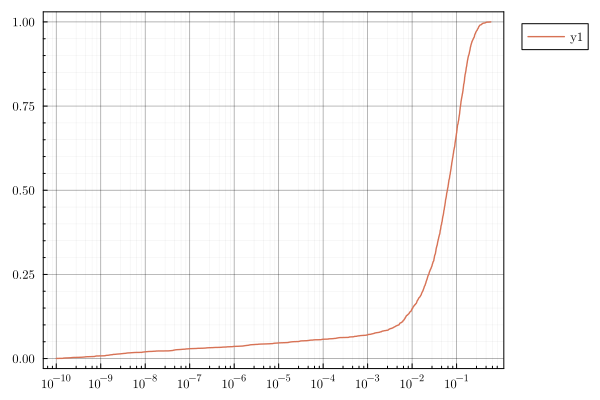

In [ ]:
plot(mewN,(1:size(mewN,1))./size(mewN,1),xscale=:log10,xticks= [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])


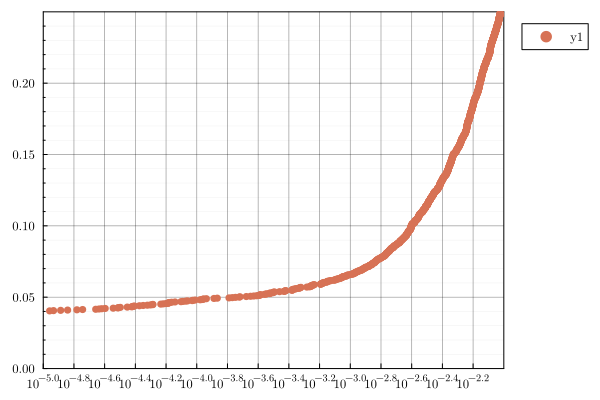

In [ ]:
scatter(mewR,(1:size(mewR,1))./size(mewR,1),xscale=:log10,xticks= 10. .^ (-5:0.2:-2),xlim=(1e-5,1e-2),ylim=(0,0.25))

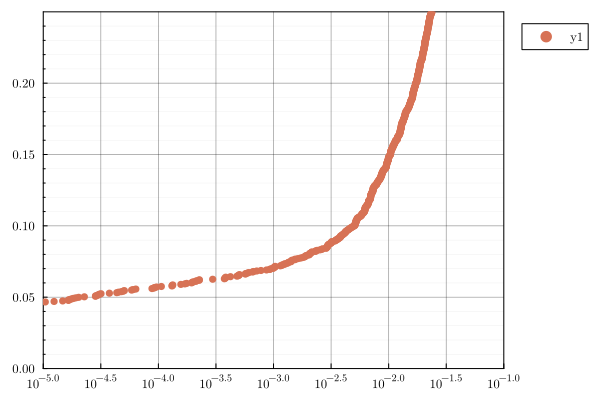

In [ ]:
scatter(mewN,(1:size(mewN,1))./size(mewN,1),xscale=:log10,xticks= 10. .^ (-5:0.5:-1),xlim=(1e-5,1e-1),ylim=(0,0.25))


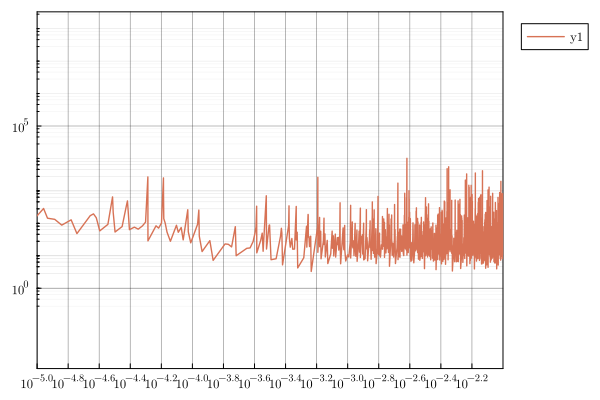

In [ ]:

plot(mewR[1:end-1],((1/size(mewR,1))./identity(diff(mewR))),xscale=:log10,xticks= 10. .^ (-5:0.2:-2),xlim=(1e-5,1e-2),yscale=:log10)


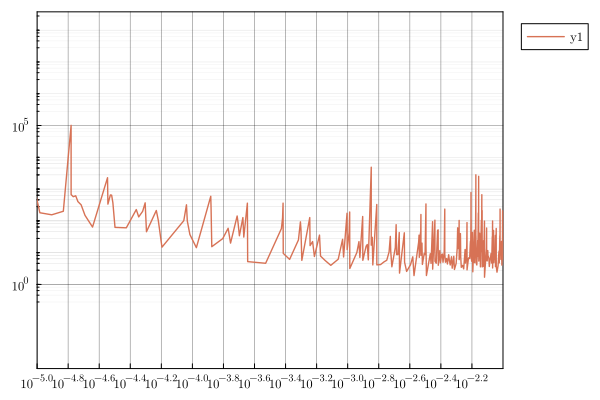

In [ ]:
plot(mewN[1:end-1],((1/size(mewN,1))./identity(diff(mewN))),xscale=:log10,xticks= 10. .^ (-5:0.2:-2),xlim=(1e-5,1e-2),yscale=:log10)
